# Preparation of Data Loader

This part refers to the preparation of data, it could be replaced with your own code. But, remember need to set the data dimension in $(B, T, C, H, W)$.

Here, I have prepared a set of HKO-7 data with the size of $(B, T, C, H, W) = (4, 45, 1, 480, 480)$.

In [1]:
import warnings
warnings.filterwarnings('ignore')  # Suppress all warnings

In [2]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import numpy as np

datapath = 'data/sample_data.npy'
data = torch.tensor(np.load(datapath)).to(device)
x, y = data[:, :5], data[:, 5:]

# Setup Model Config and ckpt

Here, I have prepared three different settings of <b>STLDM</b> to load.
1. SpatioTemporal Visual Enhancement with the img size of 128 as reported in the paper.
2. Spatial Visual Enhancement with the img size of 128 as reported in Section 4.3.3.
3. SpatioTemporal Visual Enhancement with the img size of 256 as reported in the appendix and for the sake of high resolution.

<b>Note:</b> 
- '2D' = Spatial Enhancement
- '3D' = SpatioTemporal Enhancement

In [3]:
from stldm import n2n_setup, STLDM_HKO

models = {
    'Spatial-Temporal': ('3D', 128, 'ckpts/hko-7/stldm/n2n_timesteps-50_sampling_timesteps-20_objective-pred_v_final.pt'),
    'Spatial': ('2D', 128, 'ckpts/hko-7/stldm_spatial/n2n_timesteps-50_sampling_timesteps-20_objective-pred_v_final.pt'),
    'Spatiotemporal-256': ('3D', 256, 'ckpts/hko-7/stldm_256/n2n_timesteps-50_sampling_timesteps-20_objective-pred_v_final.pt'),
}

# Setup STLDM

To setup STLDM, we need to define several things:
- ```type```: '2D' or '3D',
- ```model_config```: STLDM_HKO, you can find other in the file 'stldm/\_\_init\_\_.py',
- ```cfg_str```: any float value, or None by default (no Classifier Free Guidance)

Here is the script to do the sampling process:
```python
if model_config['pre'] is not None:
    x = model_config['pre'](x)
y_pred = model(temp_x, include_mu=False)
if model_config['post'] is not None:
    y_pred = model_config['post'](y_pred)
```

Here, we set ```include_mu = False```, to get the final prediction, $\hat{Y}$. To get the first estimation, $\bar{Y}$, as well, you can replace ```y_pred = model(temp_x, include_mu=False)``` with ```y_pred, mu = model(temp_x, include_mu=False)```. Remember, to do the post-processing on ```mu``` as well.

In [4]:
from data import dutils

model_config = STLDM_HKO
output = {'GT': y[:, :20]}

for key, (type, img_size, ckpt) in models.items():
    # Setup STLDM and Load the model checkpoint
    model = n2n_setup[type](model_config, cfg_str = 1.0).to(device)
    model.load_state_dict(torch.load(ckpt, map_location=torch.device(device)))
    model.eval()

    with torch.no_grad():
        temp_x = dutils.resize(x, img_size) # resize the input data
        if model_config['pre'] is not None:
            temp_x = model_config['pre'](temp_x)
        y_pred = model(temp_x, include_mu=False) # Set include_mu=True to fetch the first estimation
        if model_config['post'] is not None:
            y_pred = model_config['post'](y_pred)
        output[key] = y_pred
            

## Visualization

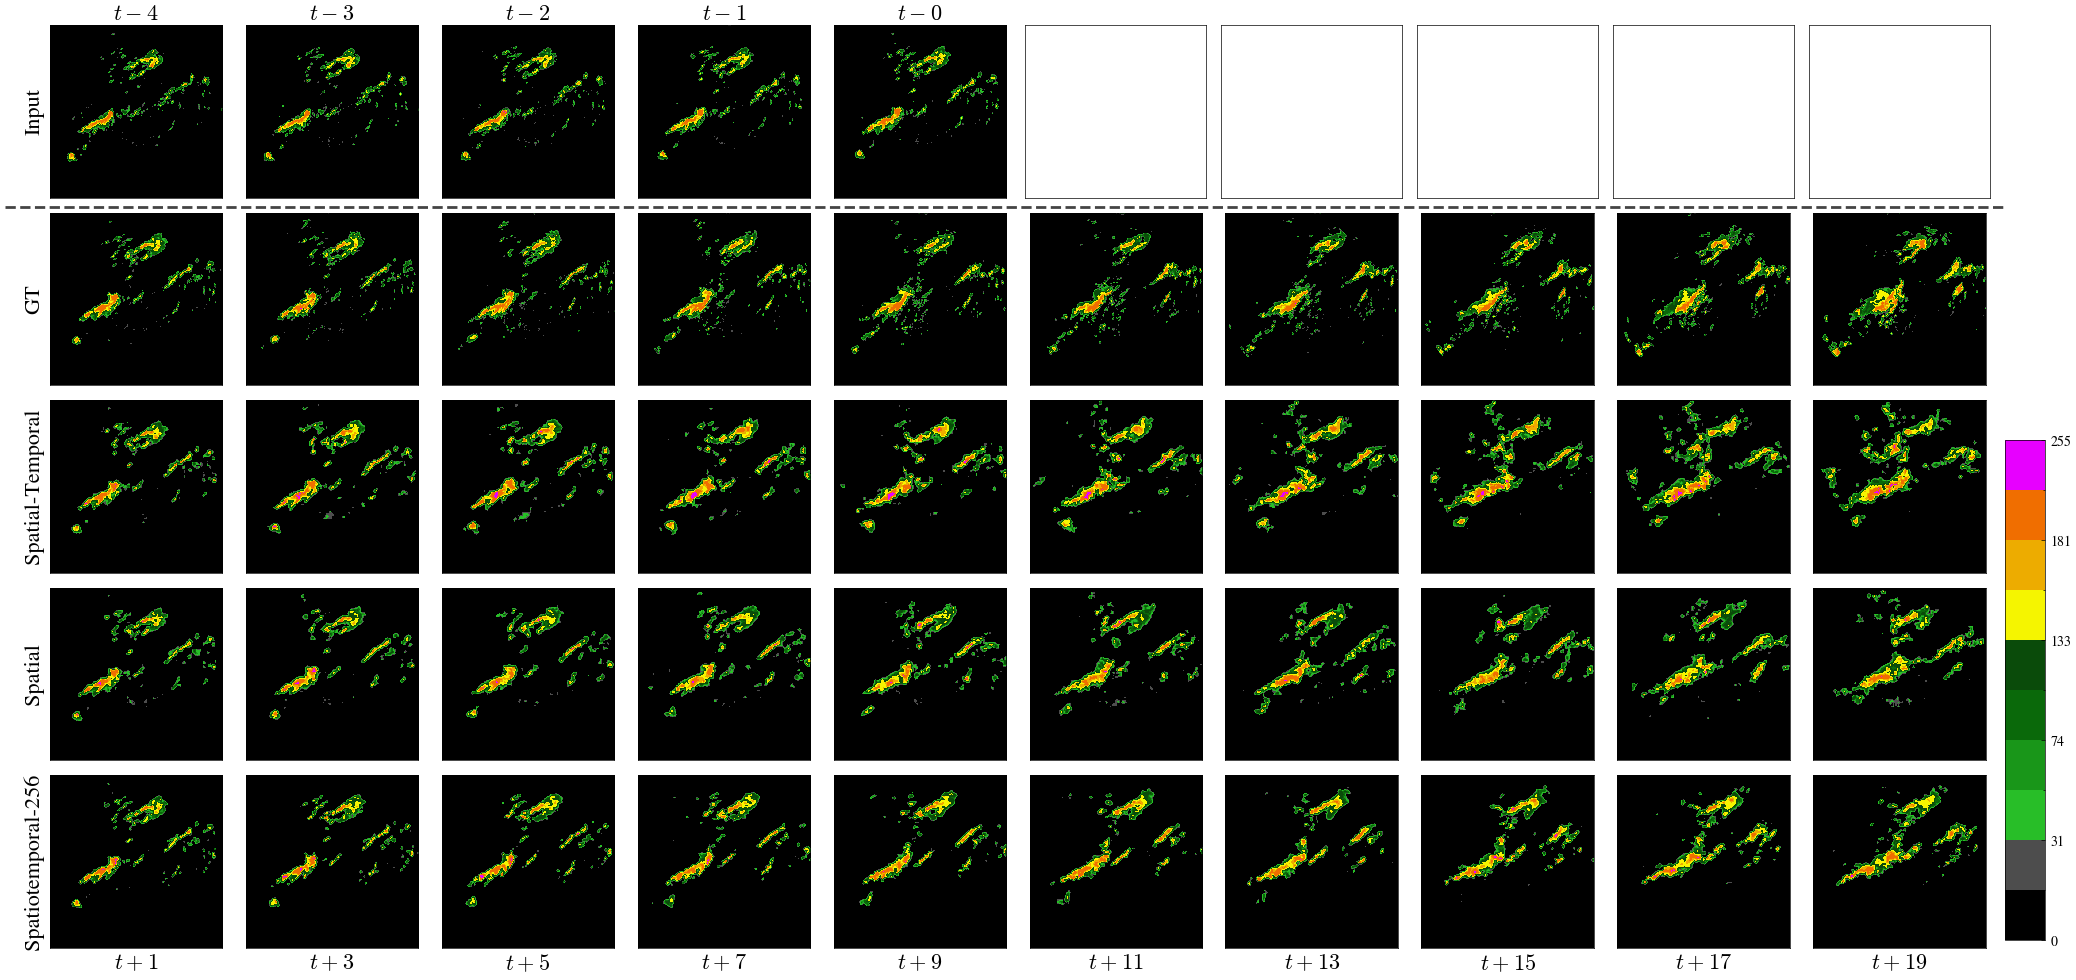

In [5]:
import utilspp as utpp
import scienceplots

b = -1

selected = {'Input': x[b].unsqueeze(0)}
for key, pred in output.items():
    selected[key] = pred[b, 0::2].unsqueeze(0)

utpp.color_visualize(selected, horizontal=10, skip=2)

# Another way to setup Classifier Free Guidance

As discussed in Section 3.1.2, Classifier-Free Guidance is to enforce the generated samples, $\hat{Y}$ follows the first estimation, $\bar{Y}$. Here, we show another way to setup the guidance scheduler explicitly for <b>STLDM</b> with the following script:
```python
guidance = guidance_scheduler(sampling_step=model_config['param']['timesteps'], const=cfg) if cfg is not None else None
model.setup_guidance(guidance)
```
To disable CFG, you can set ```guidance = None``` or ```cfg_str = None``` in ```n2n_setup``` function.

In [6]:
from stldm import guidance_scheduler

cfg_strs = [None, 0.5, 1., 1.5, 2, 2.5]

model_config = STLDM_HKO
output = {'GT': y[:, :20]}

key = 'Spatiotemporal-256'
*_, ckpt = models[key]
model = n2n_setup['3D'](model_config).to(device)
model.load_state_dict(torch.load(ckpt, map_location=torch.device(device)))
model.eval()

for cfg in cfg_strs:
    guidance = guidance_scheduler(sampling_step=model_config['param']['timesteps'], const=cfg) if cfg is not None else None
    model.setup_guidance(guidance)

    with torch.no_grad():
        temp_x = dutils.resize(x, img_size) # resize the input data
        if model_config['pre'] is not None:
            temp_x = model_config['pre'](temp_x)
        y_pred = model(temp_x, include_mu=False) # Set include_mu=True to fetch the first estimation
        if model_config['post'] is not None:
            y_pred = model_config['post'](y_pred)
        output[f'CFG = {cfg}' if cfg is not None else 'No CFG'] = y_pred

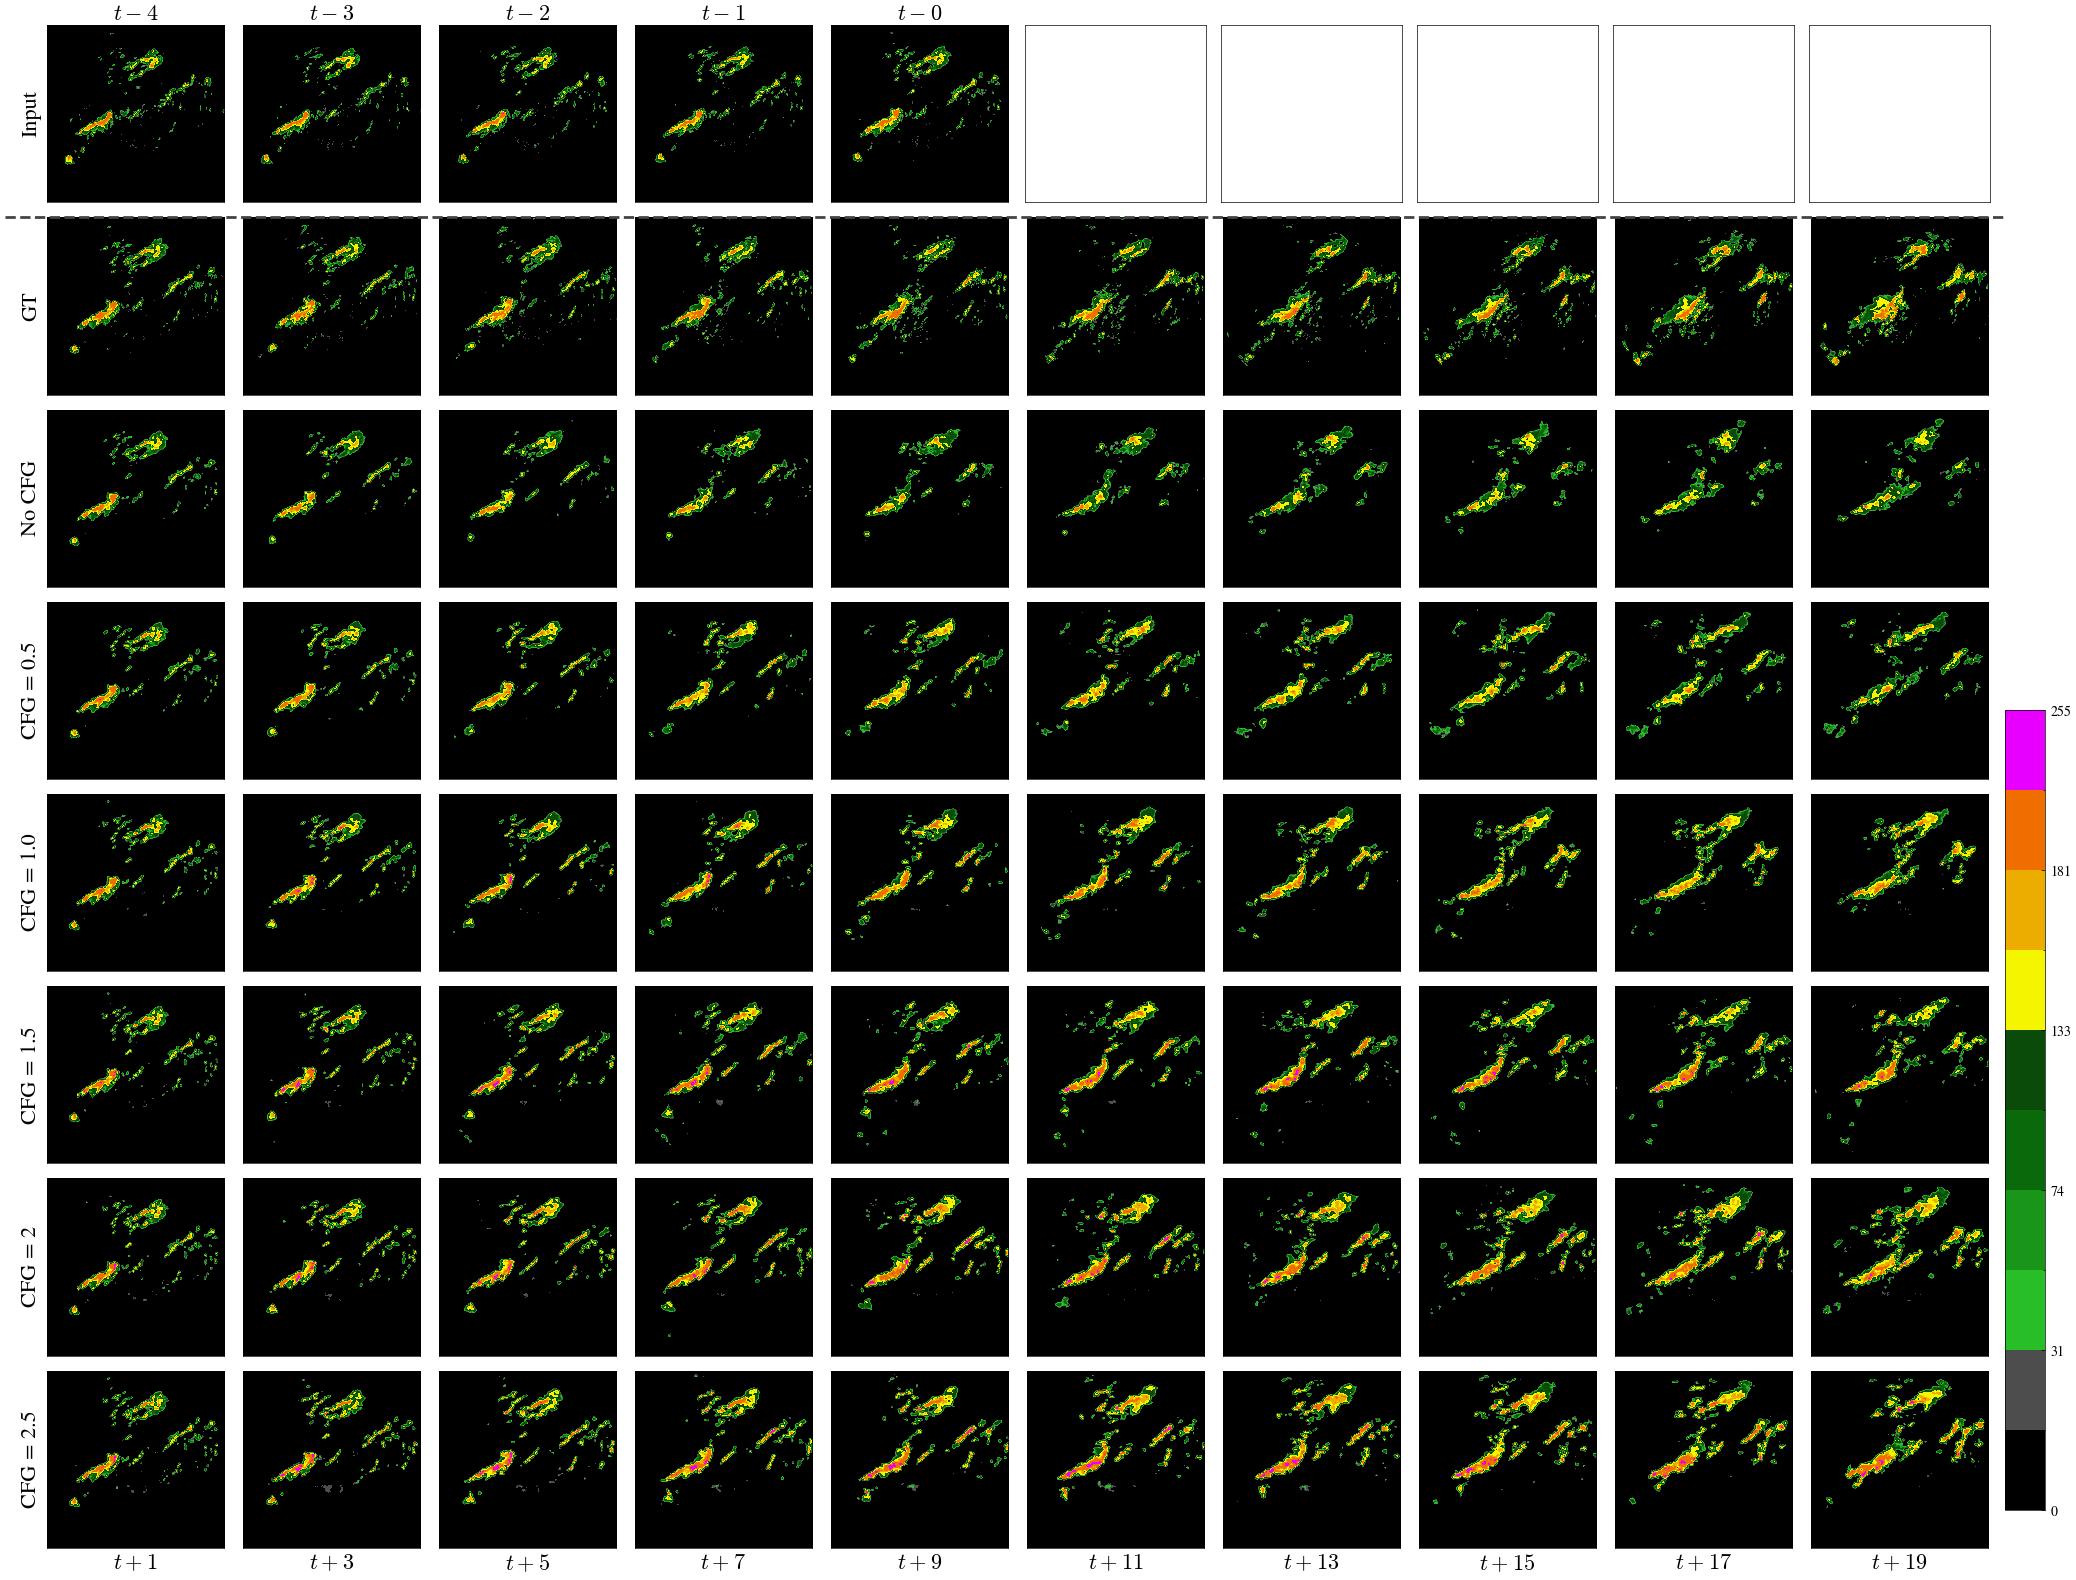

In [7]:
b = -1
selected = {'Input': x[b].unsqueeze(0)}
for key, pred in output.items():
    selected[key] = pred[b, 0::2].unsqueeze(0)

utpp.color_visualize(selected, horizontal=10, skip=2)